In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csc_matrix,bmat
import xgboost as xgb
import itertools, gc, pickle
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
%matplotlib inline

In [2]:
cols = ['tourn_num','skill_estimate_percentile','not_seen','observation_count_percentile','Start_Z_Coordinate',
        'Player_First_Name','Player_Last_Name','Cat','Distance_from_hole','Green_to_work_with',
        'from_the_tee_box_mask','Strokes_from_starting_location','Course_#','Hole','loc_string',
        'loc_string_hole','windSpeed','temperature']
data = pd.concat([pd.read_csv('../data/%d.csv.gz' % year,usecols=cols) for year in range(2003,2018)])

In [3]:
data.loc[data.from_the_tee_box_mask,'Cat'] = 'Tee Box'
data = data.drop('from_the_tee_box_mask',axis=1)

In [4]:
data.not_seen = data.not_seen.astype(float)
data.Strokes_from_starting_location = data.Strokes_from_starting_location.astype(float)
data.skill_estimate_percentile = data.skill_estimate_percentile.fillna(.5)
data.observation_count_percentile = data.observation_count_percentile.fillna(.5)
data.Start_Z_Coordinate = data.Start_Z_Coordinate/data.Distance_from_hole
data.loc[data.Start_Z_Coordinate.abs()>1,'Start_Z_Coordinate'] = data.loc[data.Start_Z_Coordinate.abs()>1,
                                                                          'Start_Z_Coordinate']\
                                                                          .apply(lambda x: 1 if x>0 else -1)
data.windSpeed = data.windSpeed.fillna(data.windSpeed.mean())
data.temperature = data.temperature.fillna(data.temperature.mean())

In [5]:
(data.Start_Z_Coordinate>0).mean()

0.27476835023104323

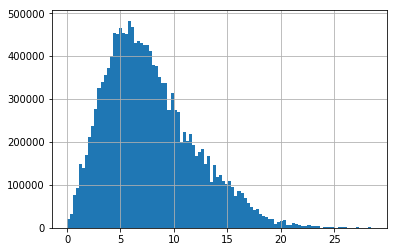

In [6]:
data.windSpeed.hist(bins=100);

In [7]:
def prepare_data(cat,num_tourns,with_distance,with_gtww,with_slope,with_skill_estimates,
                 with_course_hole,with_weather,with_locs):
    num_tournaments = len(pd.unique(data.tourn_num))
    trains = [range(i) for i in range(num_tournaments-num_tourns-1,num_tournaments-1)]
    tests = [[i] for i in range(num_tournaments-num_tourns,num_tournaments)]
    sub = data[data.Cat==cat].reset_index(drop=True)
    trains = [sub[sub.tourn_num.isin(train)].index.values for train in trains]
    tests = [sub[sub.tourn_num.isin(test)].index.values for test in tests]
    cols = []
    if with_distance: cols.append('Distance_from_hole')
    if with_gtww: cols.append('Green_to_work_with')
    if with_slope: cols.append('Start_Z_Coordinate')
    if with_skill_estimates: cols.extend(['skill_estimate_percentile','not_seen',
                                          'observation_count_percentile'])
    if with_weather: cols.extend(['windSpeed','temperature'])
    X = sub[cols].values
    y = sub.Strokes_from_starting_location.values
    if with_course_hole:
        course_strings = np.array(['%d' % (num,) for num in sub['Course_#']])
        course_hole_strings = np.array(['%d-%d' % (tup[0],tup[1])
                                        for tup in sub[['Course_#','Hole']].values])
    else:
        course_strings, course_hole_strings = [], []
    if with_locs:
        loc_strings = sub.loc_string.values
        loc_strings_hole = sub.loc_string_hole.values
    else:
        loc_strings, loc_strings_hole = [], []
    return X,y,course_strings,course_hole_strings,loc_strings,loc_strings_hole,trains,tests

In [8]:
# def find_num_trees(X,y,params,eval_pct):
#     early_stopping_rounds = 25
#     num_round = 10000
#     num_train = int(X.shape[0]*(1-eval_pct))
#     dtrain = xgb.DMatrix(X[:num_train],label=y[:num_train])
#     deval = xgb.DMatrix(X[num_train:],label=y[num_train:])
#     watchlist  = [(dtrain,'train'),(deval,'eval')]
#     params['base_score'] = y[:num_train].mean()
#     bst = xgb.train(params,dtrain,num_round,watchlist,obj=psuedo_huber,
#                     early_stopping_rounds=early_stopping_rounds,verbose_eval=False) 
#     return bst.best_iteration

# def run(cat,num_tourns,with_distance,with_gtww,with_slope,with_skill_estimates,
#         with_course_hole,with_weather,with_locs,params,eval_pct):
#     (X, y, course_strings, course_hole_strings, 
#      loc_strings, loc_strings_hole, trains, tests) = prepare_data(cat,num_tourns,with_distance,with_gtww,
#                                                                   with_slope,with_skill_estimates,
#                                                                   with_course_hole,with_weather,with_locs)
#     if with_course_hole or with_locs:
#         X = csc_matrix(X)
#     results = []
#     for u,(train,test) in enumerate(zip(trains,tests)):
#         gc.collect()
#         if with_course_hole or with_locs:
#             X_train, X_test = X.copy()[train], X.copy()[test]
#         else:
#             X_train, X_test = np.copy(X)[train], np.copy(X)[test]
#         if with_course_hole:
#             lb1 = LabelBinarizer(sparse_output=True)
#             lb2 = LabelBinarizer(sparse_output=True)
#             X_train = bmat([[X_train,lb1.fit_transform(course_strings[train]),
#                              lb2.fit_transform(course_hole_strings[train])]],format='csc')
#             X_test = bmat([[X_test,lb1.transform(course_strings[test]),
#                             lb2.transform(course_hole_strings[test])]],format='csc')
#         if with_locs:
#             lb1 = LabelBinarizer(sparse_output=True)
#             lb2 = LabelBinarizer(sparse_output=True)
#             X_train = bmat([[X_train,lb1.fit_transform(loc_strings[train]),
#                              lb2.fit_transform(loc_strings_hole[train])]],format='csc')
#             X_test = bmat([[X_test,lb1.transform(loc_strings[test]),
#                             lb2.transform(loc_strings_hole[test])]],format='csc')
        
#         if u%7==0:
#             num_trees = find_num_trees(X_train,y[train],params,eval_pct)
#         dtrain = xgb.DMatrix(X_train,label=y[train])
#         dtest = xgb.DMatrix(X_test)
#         params['base_score'] = y[train].mean()
#         bst = xgb.train(params,dtrain,num_trees)
#         preds = bst.predict(dtest)
#         error = np.mean((preds-y[test])**2)
#         mean_error = np.mean((np.mean(y[train])-y[test])**2)
#         r_sq = (mean_error-error)/mean_error
#         #print len(test),num_trees,r_sq
#         results.append(r_sq)
#     mean, std_err = np.mean(results), np.std(results)/num_tourns**.5
#     return (mean-std_err,mean+std_err)

In [9]:
cats = ['Other','Green','Fairway','Intermediate Rough','Primary Rough','Fringe','Bunker']

Just Distance

In [10]:
(X, y, course_strings, course_hole_strings, 
 loc_strings, loc_strings_hole, trains, tests) = prepare_data('Green',3,True,False,
                                                              True,True,
                                                              True,True,True)

In [11]:
X = csc_matrix(X)
for u,(train,test) in enumerate(zip(trains,tests)):
    if u<len(trains)-1: continue
    gc.collect()
    X_train = X.copy()[train]
    lb1 = LabelBinarizer(sparse_output=True)
    lb2 = LabelBinarizer(sparse_output=True)
    X_train = bmat([[X_train,lb1.fit_transform(course_strings[train]),
                     lb2.fit_transform(course_hole_strings[train])]],format='csc')
    lb3 = LabelBinarizer(sparse_output=True)
    lb4 = LabelBinarizer(sparse_output=True)
    X_train = bmat([[X_train,lb3.fit_transform(loc_strings[train]),
                     lb4.fit_transform(loc_strings_hole[train])]],format='csc')

In [12]:
X_train.shape

(6337323, 26083)

In [13]:
def psuedo_huber(preds, dtrain):
    labels = dtrain.get_label()
    delta = psuedo_huber.delta
    resids = preds - labels
    grad = resids * (1 + (resids/delta)**2)**(-.5)
    hess = (1 + (resids/delta)**2)**(-1.5)
    return grad, hess

In [14]:
psuedo_huber.delta = .6

In [15]:
dmat = xgb.DMatrix(X_train,label=y[train])

In [16]:
params = {'objective':'reg:linear','min_child_weight':4,
          'subsample':.75,'tree_method':'approx','silent':0,
          'eta':.007,'lambda':20,'max_depth':12, 'base_score':y[train].mean()}

def find_num_trees(X,y,params,eval_pct):
    early_stopping_rounds = 25
    num_round = 10000
    num_train = int(X.shape[0]*(1-eval_pct))
    dtrain = xgb.DMatrix(X[:num_train],label=y[:num_train])
    deval = xgb.DMatrix(X[num_train:],label=y[num_train:])
    watchlist  = [(dtrain,'train'),(deval,'eval')]
    params['base_score'] = y[:num_train].mean()
    bst = xgb.train(params,dtrain,num_round,watchlist,
                    early_stopping_rounds=early_stopping_rounds,verbose_eval=False) 
    return bst.best_iteration

num_trees = find_num_trees(X_train,y[train],params,eval_pct=.22)

bst = xgb.train(params,dmat,num_trees)


params = {'objective':'reg:linear','min_child_weight':4,'eval_metric':'mae',
          'subsample':.75,'tree_method':'approx','silent':0,
          'eta':.007,'lambda':20,'max_depth':12, 'base_score':y[train].mean()}

def find_num_trees(X,y,params,eval_pct):
    early_stopping_rounds = 25
    num_round = 10000
    num_train = int(X.shape[0]*(1-eval_pct))
    dtrain = xgb.DMatrix(X[:num_train],label=y[:num_train])
    deval = xgb.DMatrix(X[num_train:],label=y[num_train:])
    watchlist  = [(dtrain,'train'),(deval,'eval')]
    params['base_score'] = y[:num_train].mean()
    bst = xgb.train(params,dtrain,num_round,watchlist,obj=psuedo_huber,
                    early_stopping_rounds=early_stopping_rounds,verbose_eval=False) 
    return bst.best_iteration

num_trees = find_num_trees(X_train,y[train],params,eval_pct=.22)

bst2 = xgb.train(params,dmat,num_trees,obj=psuedo_huber)

In [197]:
bst.best_ntree_limit,bst2.best_ntree_limit

(1048, 1223)

In [199]:
y1, y2 = [],[]
for dist in np.arange(0.01,130,.5):
    x = np.zeros(X_train.shape[1])
    x[0], x[1], x[2], x[3], x[4], x[5], x[6] = dist, 0, .5, 0, .5, 0, 60
    x = csc_matrix(x[None,:])
    dmat_ = xgb.DMatrix(x)
    y1.append(bst.predict(dmat_))
    x = np.zeros(X_train.shape[1])
    x[0], x[1], x[2], x[3], x[4], x[5], x[6] = dist, 0, .5, 0, .5, 0, 60
    x = csc_matrix(x[None,:])
    dmat_1 = xgb.DMatrix(x)
    y2.append(bst2.predict(dmat_1))

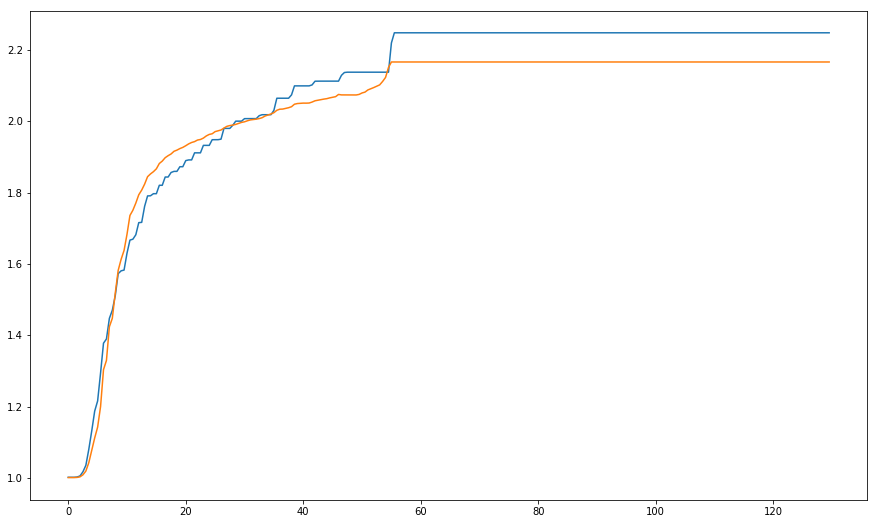

In [203]:
fig,ax = plt.subplots(1,1,figsize=(15,9))
plt.plot(np.arange(0.01,130,.5),y1);
plt.plot(np.arange(0.01,130,.5),y2);
#plt.plot(np.arange(30,1200,.5),np.array(y2)-np.array(y1));

In [220]:
y3, y4 = [],[]
for dist in np.arange(.1,100,.03):
    x = np.zeros(X_train.shape[1])
    x[0], x[1], x[2], x[3], x[4], x[5], x[6] = dist, .03, .5, 0, .5, 0, 60
    x = csc_matrix(x[None,:])
    dmat_ = xgb.DMatrix(x)
    #y3.append(bst.predict(dmat_))
    x = np.zeros(X_train.shape[1])
    x[0], x[1], x[2], x[3], x[4], x[5], x[6] = dist, -.03, .5, 0, .5, 20, 90
    x = csc_matrix(x[None,:])
    dmat_1 = xgb.DMatrix(x)
    y4.append(bst2.predict(dmat_)-bst2.predict(dmat_1))

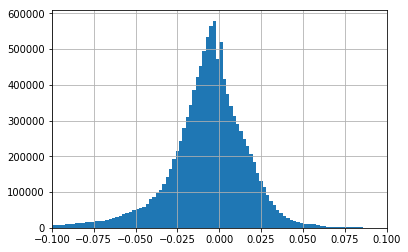

In [219]:
data.Start_Z_Coordinate.hist(bins=1000)
plt.xlim(-.1,.1);

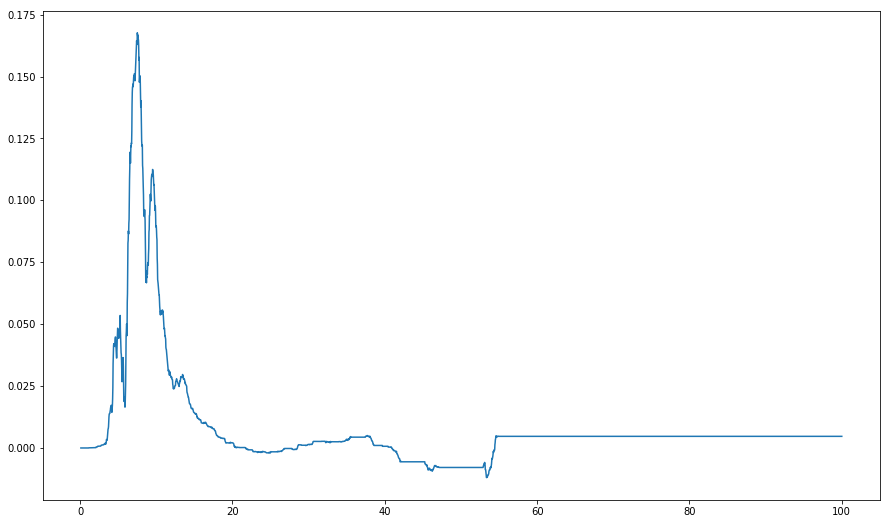

In [221]:
fig,ax = plt.subplots(1,1,figsize=(15,9))
#plt.plot(np.arange(-.3,.3,.01),y3);
plt.plot(np.arange(.1,100,.03),y4);
#plt.plot(np.arange(30,1200,.5),np.array(y4)-np.array(y3));

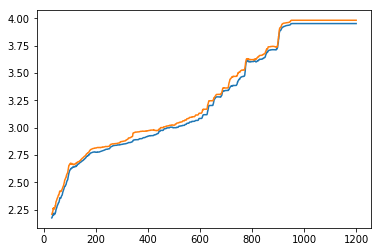

In [94]:
plt.plot(np.arange(30,1200,.5),y3);
plt.plot(np.arange(30,1200,.5),y4);
#plt.plot(np.arange(30,1200,.5),np.array(y4)-np.array(y3));

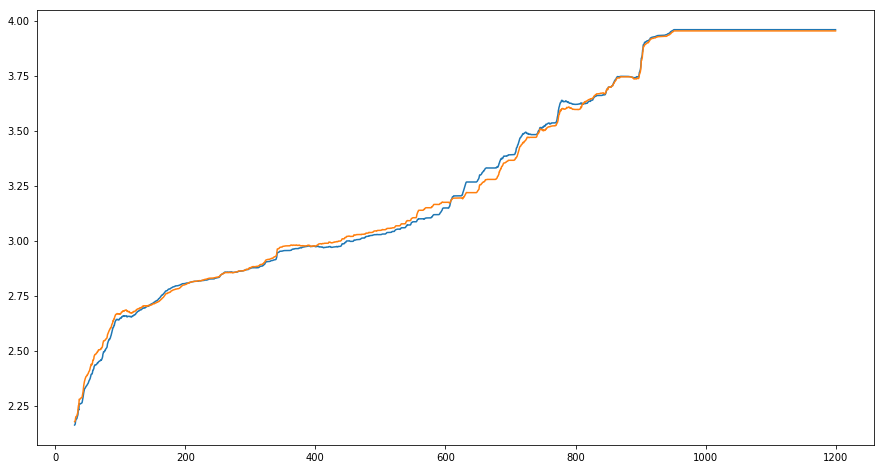

In [185]:
fig, ax = plt.subplots(1,1,figsize=(15,8))
plt.plot(np.arange(30,1200,.5),y3);
plt.plot(np.arange(30,1200,.5),y4);

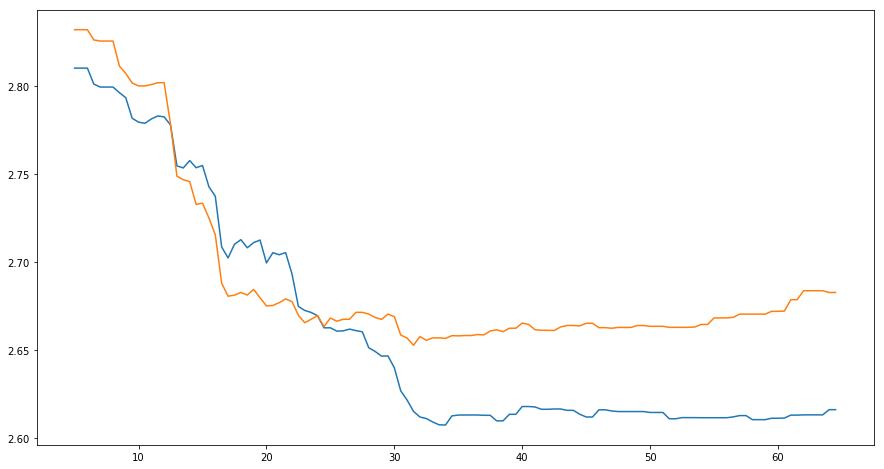

In [187]:
fig, ax = plt.subplots(1,1,figsize=(15,8))
plt.plot(np.arange(5,65,.5),y3);
plt.plot(np.arange(5,65,.5),y4);

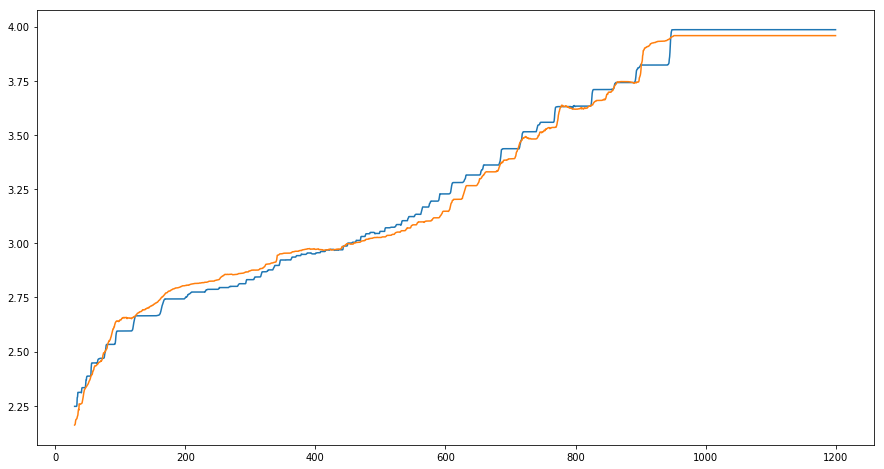

In [120]:
fig, ax = plt.subplots(1,1,figsize=(15,8))
plt.plot(np.arange(30,1200,.5),y1);
plt.plot(np.arange(30,1200,.5),y3);

In [151]:
vals = []
for sk_est in np.arange(0.01,1,.01):
    vals_ = []
    for obs_count in np.arange(0.01,1,.1):
        x = np.zeros(X_train.shape[1])
        x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7] = 300, 30, 0, sk_est, 0, obs_count, 20, 60
        x = csc_matrix(x[None,:])
        dmat_ = xgb.DMatrix(x)
        vals_.append(bst.predict(dmat_)[0])
    vals.append(vals_)
vals = np.array(vals).T

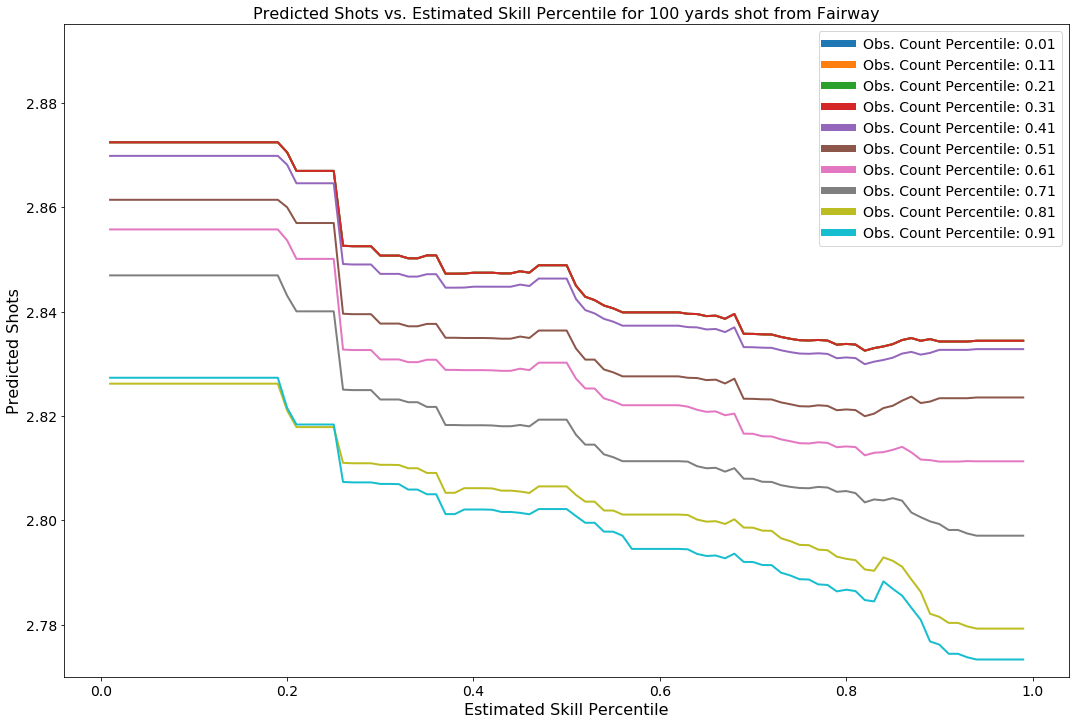

In [181]:
fig, ax = plt.subplots(1,1,figsize=(18,12))
for obs_count,val_ in zip(np.arange(0.01,1,.1),vals):
    plt.plot(np.arange(0.01,1,.01),val_,label='Obs. Count Percentile: %g' % obs_count,lw=2);
leg = plt.legend(loc=1,prop={'size':14})
for legobj in leg.legendHandles:
    legobj.set_linewidth(7.0)
plt.title('Predicted Shots vs. Estimated Skill Percentile for 100 yards shot from Fairway',fontsize=16);
plt.xlabel('Estimated Skill Percentile',fontsize=16);
plt.ylabel('Predicted Shots',fontsize=16);
ax.tick_params(labelsize=14);
plt.ylim(2.77,2.895);
plt.savefig('skill_vs_predicted_shots.png',dpi=130)

In [228]:
y1, y2 = [],[]
for dist in np.arange(0.01,88,.09):
    x = np.zeros(X_train.shape[1])
    x[0], x[1], x[2], x[3], x[4], x[5], x[6] = dist, 0, .5, 0, .5, 0, 60
    x = csc_matrix(x[None,:])
    dmat_ = xgb.DMatrix(x)
    y1.append(bst2.predict(dmat_))
    x = np.zeros(X_train.shape[1])
    x[0], x[1], x[2], x[3], x[4], x[5], x[6] = dist, 0, .8, 0, .8, 0, 60
    x = csc_matrix(x[None,:])
    dmat_1 = xgb.DMatrix(x)
    y2.append(bst2.predict(dmat_1))

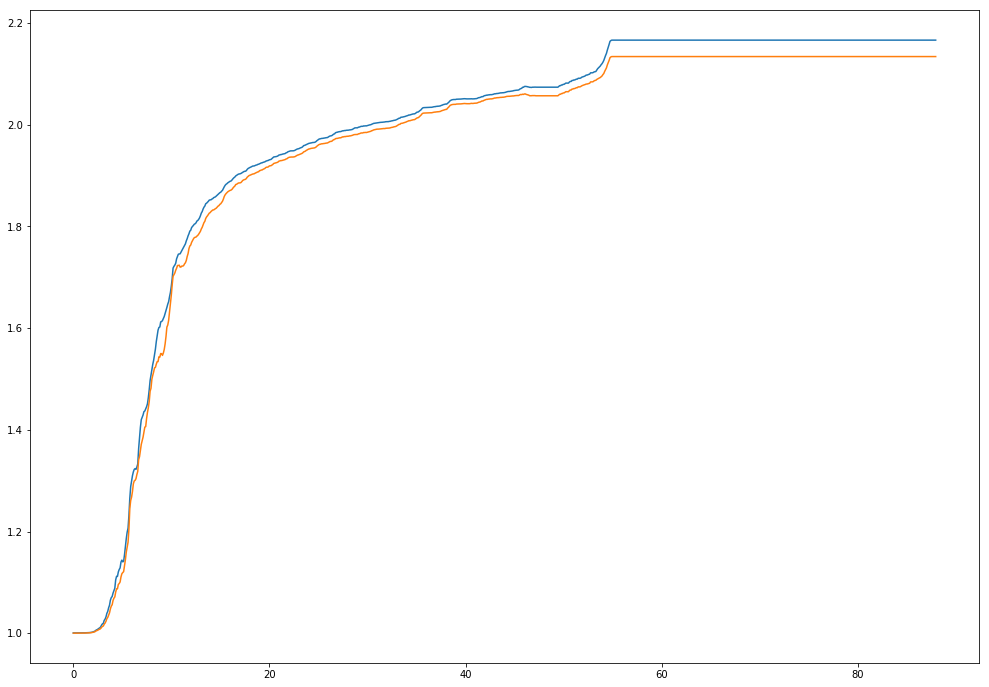

In [229]:
fig, ax = plt.subplots(1,1,figsize=(17,12))
plt.plot(np.arange(0.01,88,.09),y1);
plt.plot(np.arange(0.01,88,.09),y2);

In [232]:
vals = []
for sk_est in np.arange(0.01,1,.01):
    vals_ = []
    for obs_count in np.arange(0.01,1,.1):
        x = np.zeros(X_train.shape[1])
        x[0], x[1], x[2], x[3], x[4], x[5], x[6] = 5, 0, sk_est, 0, obs_count, 0, 60
        x = csc_matrix(x[None,:])
        dmat_ = xgb.DMatrix(x)
        vals_.append(bst2.predict(dmat_)[0])
    vals.append(vals_)
vals = np.array(vals).T

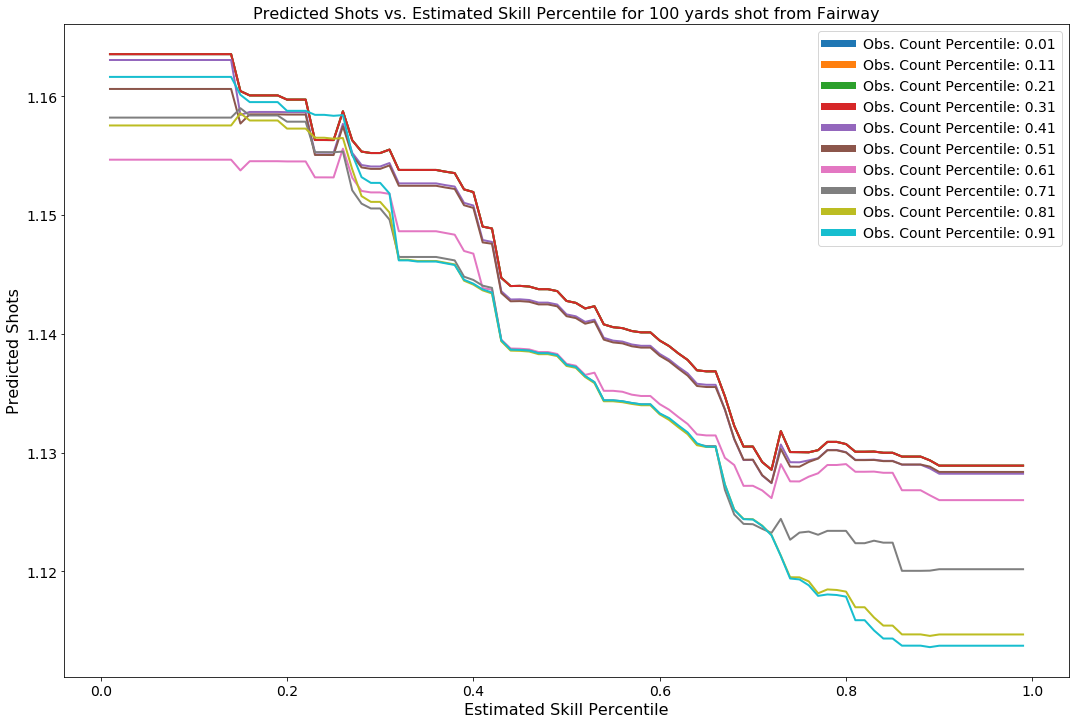

In [233]:
fig, ax = plt.subplots(1,1,figsize=(18,12))
for obs_count,val_ in zip(np.arange(0.01,1,.1),vals):
    plt.plot(np.arange(0.01,1,.01),val_,label='Obs. Count Percentile: %g' % obs_count,lw=2);
leg = plt.legend(loc=1,prop={'size':14})
for legobj in leg.legendHandles:
    legobj.set_linewidth(7.0)
plt.title('Predicted Shots vs. Estimated Skill Percentile for 100 yards shot from Fairway',fontsize=16);
plt.xlabel('Estimated Skill Percentile',fontsize=16);
plt.ylabel('Predicted Shots',fontsize=16);
ax.tick_params(labelsize=14);
#plt.ylim(2.77,2.895);
#plt.savefig('skill_vs_predicted_shots.png',dpi=130)

In [240]:
y1, y2 = [],[]
for dist in np.arange(0.01,88,.09):
    x = np.zeros(X_train.shape[1])
    x[0], x[1], x[2], x[3], x[4], x[5], x[6] = dist, 0, .5, 0, .5, 0, 90
    x = csc_matrix(x[None,:])
    dmat_ = xgb.DMatrix(x)
    y1.append(bst2.predict(dmat_))
    x = np.zeros(X_train.shape[1])
    x[0], x[1], x[2], x[3], x[4], x[5], x[6] = dist, 0, .5, 0, .5, 0, 40
    x = csc_matrix(x[None,:])
    dmat_1 = xgb.DMatrix(x)
    y2.append(bst2.predict(dmat_1))

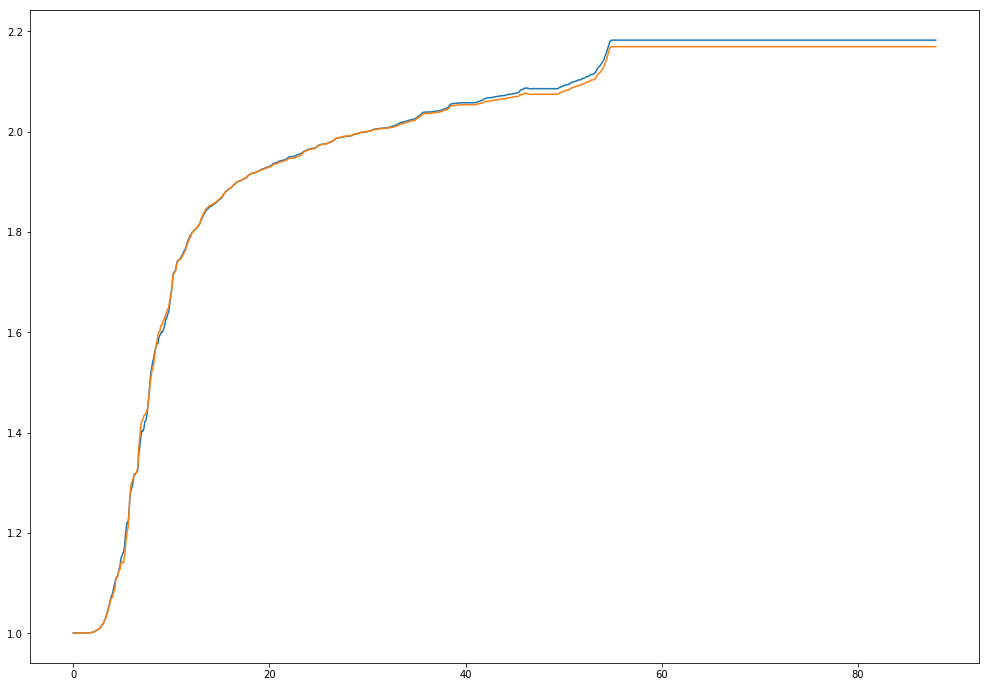

In [241]:
fig, ax = plt.subplots(1,1,figsize=(17,12))
plt.plot(np.arange(0.01,88,.09),y1);
plt.plot(np.arange(0.01,88,.09),y2);

In [38]:
x = np.zeros(7)
x[0], x[1], x[2], x[3], x[4], x[5], x[6] = 30, 0, .5, 0, .5, 0, 70
x = csc_matrix(x)
x = bmat([[x,lb1.transform(['5']),lb2.transform(['5-14'])]],format='csc')
x = bmat([[x,lb3.transform(['5-14-3-0']),lb4.transform(['5-14-1-1'])]],format='csc')
dmat_ = xgb.DMatrix(x)

In [31]:
bst2.predict(dmat_)

array([ 2.00817633], dtype=float32)

In [33]:
bst2.predict(dmat_)

array([ 2.00870013], dtype=float32)

In [39]:
bst2.predict(dmat_)

array([ 2.00817633], dtype=float32)

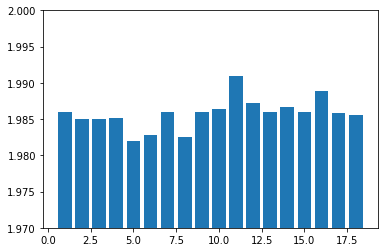

In [49]:
y = []
for hole in range(1,19):
    x = np.zeros(7)
    x[0], x[1], x[2], x[3], x[4], x[5], x[6] = 30, 0, .5, 0, .5, 0, 70
    x = csc_matrix(x)
    x = bmat([[x,lb1.transform(['21']),lb2.transform(['21-%d' % (hole,)])]],format='csc')
    x = bmat([[x,lb3.transform(['21-%d-3-0' % (hole,)]),lb4.transform(['21-%s-1-1' % (hole,)])]],format='csc')
    dmat_ = xgb.DMatrix(x)
    y.append(bst2.predict(dmat_)[0])
plt.bar(range(1,19),y);
plt.ylim(1.97,2.0);

In [75]:
res = []
for dist in range(1,75,2):
    print dist
    y = []
    for u,(course,hole) in enumerate(itertools.product(pd.unique(data['Course_#']),range(1,19))):
        x = np.zeros(7)
        x[0], x[1], x[2], x[3], x[4], x[5], x[6] = dist, 0, .5, 0, .5, 0, 70
        x = csc_matrix(x)
        x = bmat([[x,lb1.transform(['%d' % (course,)]),lb2.transform(['%d-%d' % (course,hole)])]],format='csc')
        x = bmat([[x,lb3.transform(['%d-%d-3-0' % (course,hole,)]),
                   lb4.transform(['%d-%s-1-1' % (course,hole)])]],format='csc')
        dmat_ = xgb.DMatrix(x)
        y.append(bst2.predict(dmat_)[0])
    res.append((np.mean(y),np.std(y),np.std(y)/np.mean(y)))

1
3
5
7
9
11
13
15
17
19
21
23
25
27
29
31
33
35
37
39
41
43
45
47
49
51
53
55
57
59
61
63
65
67
69
71
73


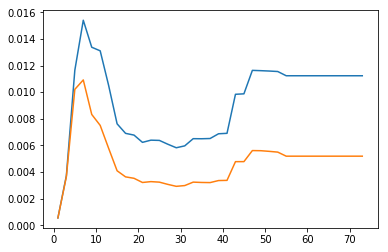

In [85]:
plt.plot(range(1,75,2),[r[1] for r in res]);
plt.plot(range(1,75,2),[r[2] for r in res]);

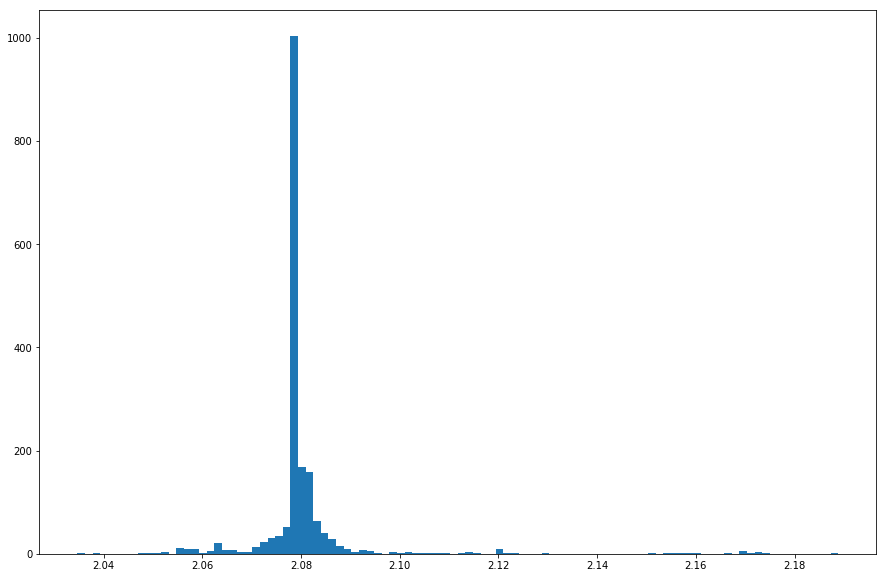

In [70]:
fig,ax = plt.subplots(1,1,figsize=(15,10))
plt.hist(y,bins=100);
# plt.bar(range(1800),y);
# plt.ylim(1.9,2.1);
# plt.xlim(18,36);

In [71]:
pd.Series(y).describe()

count    1800.000000
mean        2.080493
std         0.011613
min         2.034695
25%         2.079180
50%         2.079391
75%         2.080357
max         2.188840
dtype: float64

In [29]:
X_train.shape

(6337323, 26083)

In [11]:
with open('results1.pkl','rb') as pickle_file:
    results1 = pickle.load(pickle_file)

In [ ]:
#results1 = {}
for cat in cats:
    if cat not in results1:
        results1[cat] = {}
    for de,su,mw,la,et,ep in itertools.product(depths,subsample,min_weight,lamba,eta,eval_pct):
        if (de,su,mw,la,et,ep) in results1[cat]: continue
        params = {'objective':'reg:linear','min_child_weight':mw,
                  'subsample':su,'tree_method':'approx','silent':0,
                  'eta':et,'lambda':la,'max_depth':de}
        gc.collect()
        res = run(cat,25,True,False,False,False,False,False,False,params,ep)
        print cat,(de,su,mw,la,et,ep),res,(datetime.now() - timedelta(hours=7)).strftime('%H:%M:%S')
        results1[cat][(de,su,mw,la,et,ep)] = res
        with open('results1.pkl','wb') as pickle_file:
            pickle.dump(results1,pickle_file)
        !rsync -qavL -e "ssh -i /home/ubuntu/aws_ds8key.pem" results1.pkl ubuntu@ec2-54-144-40-79.compute-1.amazonaws.com:~

Green (3, 0.8, 1, 50, 0.03, 0.05) (0.58363178687119777, 0.59604926812699843) 12:50:43


With Everything but Skill Estimates

In [ ]:
with open('results2.pkl','rb') as pickle_file:
    results2 = pickle.load(pickle_file)

In [ ]:
#results2 = {}
for cat in cats:
    if cat not in results2:
        results2[cat] = {}
    for de,su,mw,la,et,ep in itertools.product(depths,subsample,min_weight,lamba,eta,eval_pct):
        if (de,su,mw,la,et,ep) in results2[cat]: continue
        params = {'objective':'reg:linear','min_child_weight':mw,
                  'subsample':su,'tree_method':'approx','silent':0,
                  'eta':et,'lambda':la,'max_depth':de}
        gc.collect()
        res = run(cat,25,True,cat!='Green',True,False,True,True,True,params,ep)
        print cat,(de,su,mw,la,et,ep),res,(datetime.now() - timedelta(hours=7)).strftime('%H:%M:%S')
        results2[cat][(de,su,mw,la,et,ep)] = res
        with open('results2.pkl','wb') as pickle_file:
            pickle.dump(results2,pickle_file)
        !rsync -qavL -e "ssh -i /home/ubuntu/aws_ds8key.pem" results2.pkl ubuntu@ec2-54-144-40-79.compute-1.amazonaws.com:~

With Everything

In [ ]:
with open('results3.pkl','rb') as pickle_file:
    results3 = pickle.load(pickle_file)

In [ ]:
#results3 = {}
for cat in cats:
    if cat not in results3:
        results3[cat] = {}
    for de,su,mw,la,et,ep in itertools.product(depths,subsample,min_weight,lamba,eta,eval_pct):
        if (de,su,mw,la,et,ep) in results3[cat]: continue
        params = {'objective':'reg:linear','min_child_weight':mw,
                  'subsample':su,'tree_method':'approx','silent':0,
                  'eta':et,'lambda':la,'max_depth':de}
        gc.collect()
        res = run(cat,25,True,cat!='Green',True,True,True,True,True,params,ep)
        print cat,(de,su,mw,la,et,ep),res,(datetime.now() - timedelta(hours=7)).strftime('%H:%M:%S')
        results3[cat][(de,su,mw,la,et,ep)] = res
        with open('results3.pkl','wb') as pickle_file:
            pickle.dump(results3,pickle_file)
        !rsync -qavL -e "ssh -i /home/ubuntu/aws_ds8key.pem" results3.pkl ubuntu@ec2-54-144-40-79.compute-1.amazonaws.com:~